In [1]:
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from astropy.visualization import simple_norm

In [21]:
from astropy.io import fits
from astropy.table import Table
from astropy import wcs
import numpy as np
import warnings

In [22]:
cd background_estimation/

[Errno 2] No such file or directory: 'background_estimation/'
/orange/adamginsburg/jwst/jw02731/background_estimation


In [23]:
import regions
rois = regions.Regions.read('/orange/adamginsburg/jwst/jw02731/background_estimation/three_check_regions.reg')
r0, r1, r2 = rois

In [35]:
def check_image(hdu, catalog=None, colorcol='flux', noface=False, min_percent=0.1, max_percent=99, stretch='asinh', cmap='inferno'):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ww = wcs.WCS(hdu.header)
        data = hdu.data

        pl.figure(figsize=(22,8))
        for ii,rr in enumerate((r0,r1,r2)):
            mask = rr.to_pixel(ww).to_mask()
            mdata = mask.cutout(data)
            bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)
            ax = pl.subplot(1,3, ii+1, projection=ww[bigslc])
            ax.imshow(mdata, norm=simple_norm(mdata, min_percent=min_percent, max_percent=max_percent, stretch=stretch), cmap=cmap)
            axlims = ax.axis()
            if catalog:
                if 'x_fit' in catalog.colnames:
                    xx = catalog['x_fit'] - bigslc[1].start
                    yy = catalog['y_fit'] - bigslc[0].start
                    cc = catalog[f'{colorcol}_fit']
                elif 'xcentroid' in catalog.colnames:
                    xx = catalog['xcentroid'] - bigslc[1].start
                    yy = catalog['ycentroid'] - bigslc[0].start
                    cc = catalog[f'{colorcol}']
                else:
                    raise ValueError(str(catalog.colnames))
                if noface:
                    ax.scatter(xx, yy, marker='o', facecolor='none', edgecolor='white)
                else:
                    ax.scatter(xx, yy, marker='o', c=cc, cmap='jet')
                ax.axis(axlims)

In [6]:
def plot_with_catalog(filtername):
    hdu = fits.open(f'{filtername}_filter-based-background-subtraction.fits')[0]
    catalog = Table.read(f'{filtername}_fullfield_ePSF_photometry.fits')
    #print(catalog)
    check_image(hdu, catalog)

In [20]:
plot_with_catalog('F335M')

NameError: name 'warnings' is not defined

Set DATE-AVG to '2022-06-03T12:17:28.687' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.567090 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654334357.166 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(slice(5731, 6300, None), slice(10267, 10830, None))
(slice(4595, 5386, None), slice(4974, 5795, None))
(slice(2461, 3381, None), slice(7407, 8300, None))


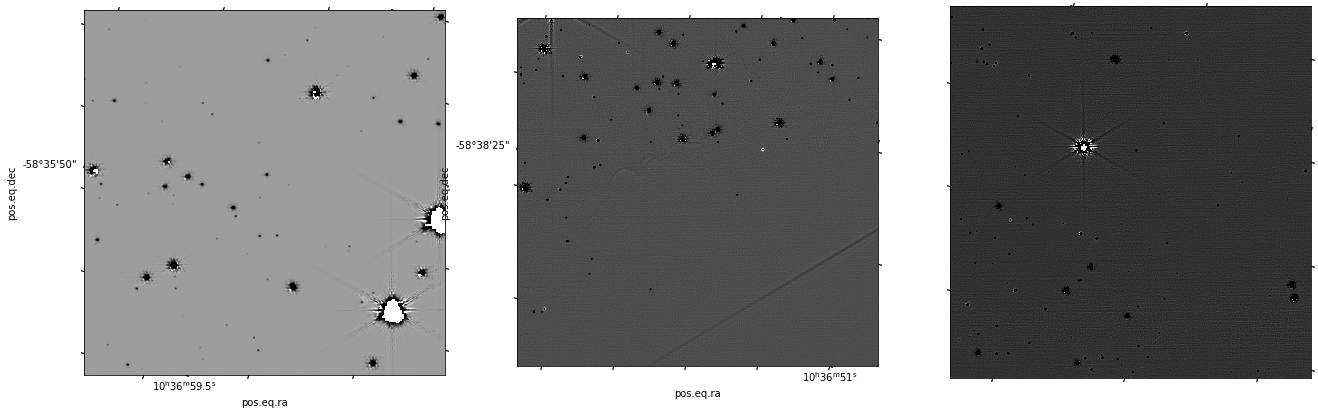

In [8]:
plot_with_catalog('F090W')

In [9]:
%run ../code/filtering.py

/orange/adamginsburg/jwst/jw02731/code/filtering.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.568124 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654350045.384 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.568124 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654350045.384 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


(slice(2788, 3072, None), slice(5072, 5353, None))
(slice(2245, 2640, None), slice(2440, 2850, None))
(slice(1176, 1635, None), slice(3639, 4085, None))


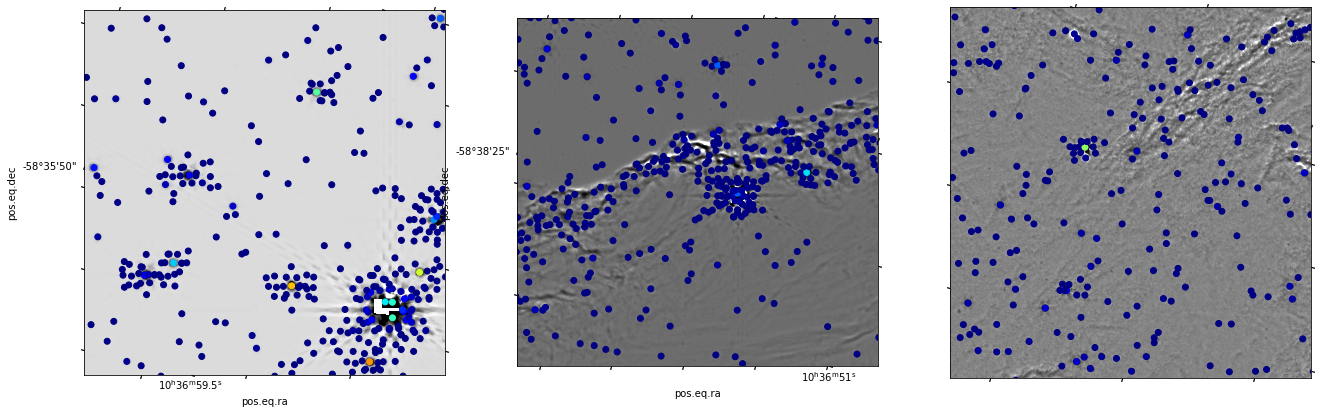

In [16]:
filtername = 'F335M'

hdu = fits.open(f'{filtername}_filter-based-background-subtraction.fits')[0]
catalog = Table.read(f'{filtername}_fullfield_ePSF_photometry.fits')
filtered_data = hdu.data
fwhm, fwhm_pix = get_fwhm(hdu.header)

nsigma_threshold = 10
filtered_errest = stats.mad_std(filtered_data, ignore_nan=True)

daofind_fin = DAOStarFinder(threshold=nsigma_threshold * filtered_errest, fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)
finstars = daofind_fin(filtered_data)

check_image(hdu=hdu, catalog=finstars)

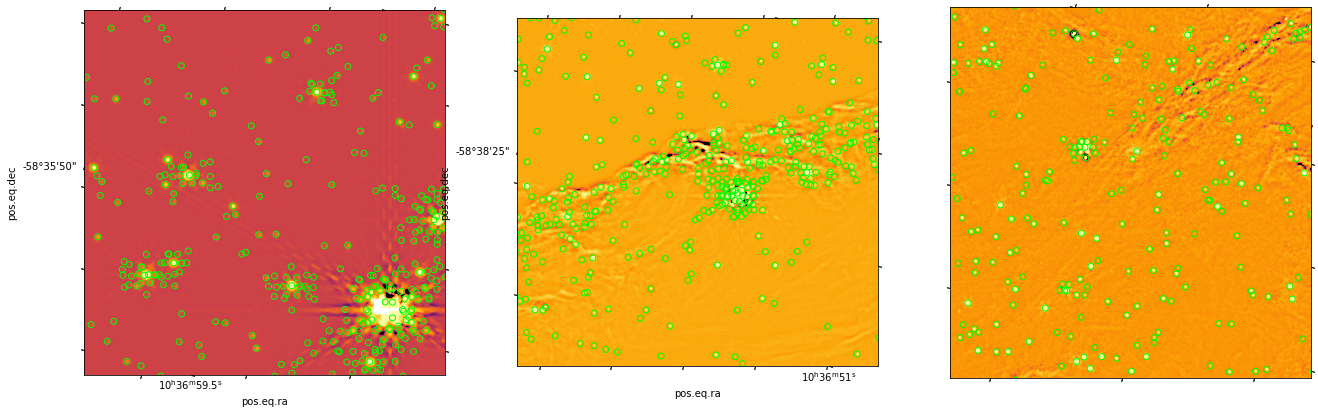

In [36]:
check_image(hdu=hdu, catalog=finstars, noface=True, max_percent=99.5, min_percent=0.1, stretch='log')